# Logistic Regression

This notebook will demonstrate an application of Logistic Regression on the [IBMEmployeeAttrition](https://github.com/Madison-Bunting/INDE-577/blob/main/IBMEmployeeAttrition.csv) dataset.

In [41]:
#Always include important imports at the top
import numpy as np #for linear algebra functions
import pandas as pd #for data processing the CSV

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn imports
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report #for nice result formatting
from sklearn.metrics import roc_curve, auc

#importing the dataset as a dataframe
df = pd.read_csv("https://raw.githubusercontent.com/Madison-Bunting/INDE-577/main/IBMEmployeeAttrition.csv")

Preprocess the data by removing variables with zero variance (as uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook.

In [42]:
#Drop variables with zero variance: EmployeeCount, Over18, and StandardHours
df.drop('EmployeeCount', axis = 1, inplace = True)
df.drop('Over18', axis = 1, inplace = True)
df.drop('StandardHours', axis = 1, inplace = True)

Correlated variables will impact logistic regression outputs, so those should be dropped as well. As uncovered in the [Exploring A New Dataset](https://github.com/Madison-Bunting/INDE-577/blob/main/Exploring%20a%20New%20Dataset.ipynb) Notebook, we should drop Job Level, Total Working Years, Years in Current Role, Years with Current Manager, and Percent Salary Hike.

In [43]:
#Dropping variables listed above that are correlated
df_final = df.drop(['JobLevel','TotalWorkingYears','YearsInCurrentRole', 'YearsWithCurrManager' , 'PercentSalaryHike'], axis=1)
#Confirm those variables were sucessfully dropped
df_final

Age Attrition     BusinessTravel  DailyRate              Department  \
0      41       Yes      Travel_Rarely       1102                   Sales   
1      49        No  Travel_Frequently        279  Research & Development   
2      37       Yes      Travel_Rarely       1373  Research & Development   
3      33        No  Travel_Frequently       1392  Research & Development   
4      27        No      Travel_Rarely        591  Research & Development   
...   ...       ...                ...        ...                     ...   
1465   36        No  Travel_Frequently        884  Research & Development   
1466   39        No      Travel_Rarely        613  Research & Development   
1467   27        No      Travel_Rarely        155  Research & Development   
1468   49        No  Travel_Frequently       1023                   Sales   
1469   34        No      Travel_Rarely        628  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeNumber  \
0                    1          2  Life Sciences               1   
1                    8          1  Life Sciences               2   
2                    2          2          Other               4   
3                    3          4  Life Sciences               5   
4                    2          1        Medical               7   
...                ...        ...            ...             ...   
1465                23          2        Medical            2061   
1466                 6          1        Medical            2062   
1467                 4          3  Life Sciences            2064   
1468                 2          3        Medical            2065   
1469                 8          3        Medical            2068   

      EnvironmentSatisfaction  ... MonthlyRate  NumCompaniesWorked  OverTime  \
0                           2  ...       19479                   8       Yes   
1                           3  ...       24907                   1        No   
2                           4  ...        2396                   6       Yes   
3                           4  ...       23159                   1       Yes   
4                           1  ...       16632                   9        No   
...                       ...  ...         ...                 ...       ...   
1465                        3  ...       12290                   4        No   
1466                        4  ...       21457                   4        No   
1467                        2  ...        5174                   1       Yes   
1468                        4  ...       13243                   2        No   
1469                        2  ...       10228                   2        No   

     PerformanceRating  RelationshipSatisfaction StockOptionLevel  \
0                    3                         1                0   
1                    4                         4                1   
2                    3                         2                0   
3                    3                         3                0   
4                    3                         4                1   
...                ...                       ...              ...   
1465                 3                         3                1   
1466                 3                         1                1   
1467                 4                         2                1   
1468                 3                         4                0   
1469                 3                         1                0   

      TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
0                         0                1               6   
1                         3                3              10   
2                         3                3               0   
3                         3                3               8   
4                         3                3               2   
...                     ...              ...             ...   
1465                      

## Pre-Processing
Before we can run logistic regression, we need to pre-process the data and encode labels. We will do this using sklearn's preprocessing package.

In [44]:
#Create a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    res_df = df.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['BusinessTravel'] = le.fit_transform(res_df['BusinessTravel'])
    res_df['Department'] = le.fit_transform(res_df['Department'])
    res_df['Education'] = le.fit_transform(res_df['Education'])
    res_df['EducationField'] = le.fit_transform(res_df['EducationField'])
    res_df['JobRole'] = le.fit_transform(res_df['JobRole'])
    res_df['Gender'] = le.fit_transform(res_df['Gender'])
    res_df['MaritalStatus'] = le.fit_transform(res_df['MaritalStatus'])
    res_df['OverTime'] = le.fit_transform(res_df['OverTime'])
    res_df['Attrition'] = le.fit_transform(res_df['Attrition'])
    return res_df

#Run the function on the desired dataset
encoded_df = preprocessor(df_final)

The next step is to select which features we want to use with logistic regression and standardize them.

In [45]:
#Selecting features
X = encoded_df.drop(['Attrition'],axis =1)
y = encoded_df['Attrition']
y

0       1
1       0
2       1
3       0
4       0
       ..
1465    0
1466    0
1467    0
1468    0
1469    0
Name: Attrition, Length: 1470, dtype: int32

In [46]:
#Standardizing features
sc = StandardScaler()
X = sc.fit_transform(X)

#Confirm the new mean and standard deviation of the dataset
mean = np.mean(X, axis=0)
print('Mean: (%d, %d)' % (mean[0], mean[1]))
standard_deviation = np.std(X, axis=0)
print('Standard deviation: (%d, %d)' % (standard_deviation[0], standard_deviation[1]))

Mean: (0, 0)
Standard deviation: (1, 1)


## Split into Train and Test data
To apply logistic regression, the data must be split into "training" and "test" data.

In [47]:
#Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 40)

In [48]:
#Instantiate the model
logreg = LogisticRegression()
#Fit the model with data
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)

# Performance Analysis
The next step is to conduct a performance analysis of the model. We do this by examining the confusion matrix and the Receiver Operating Characteristic (ROC) curve.

In [49]:
print("Accuracy:", accuracy_score(y_test,y_pred))

Accuracy: 0.8994565217391305


Text(0.5, 257.44, 'Predicted label')

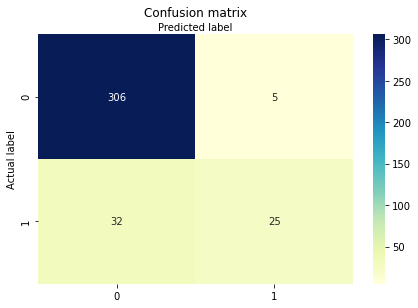

In [50]:
#Creating the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes

#Creating the figure
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#Adding the heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [51]:
#Print a nicely formatted report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       311
           1       0.83      0.44      0.57        57

    accuracy                           0.90       368
   macro avg       0.87      0.71      0.76       368
weighted avg       0.89      0.90      0.89       368



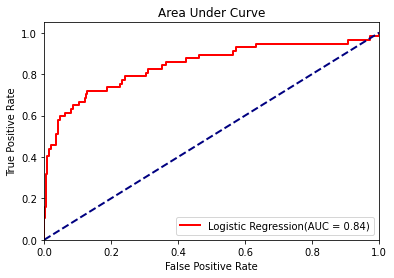

In [54]:
#Plot the ROC curve
y_prob = logreg.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Logistic Regression(AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Curve')
plt.legend(loc="lower right")
plt.show()
